<h1 style="color:rgb(0,120,170)"><b>Master Thesis - Evaluating Offline Reinforcement Learning Under Suboptimal Data Quality: A Comparative Study of BC, BVE and IQL
</b></h1>
<h2 style="color:rgb(0,120,170)"><u>Part 1: Dataset creation</u></h2>

<b>Author:</b> Manuel Sperl<br>
<b>Date:</b> 2025

This notebook is part of my master’s thesis project. The goal is to generate diverse offline reinforcement learning (RL) datasets for evaluating three algorithms — Behavioral Cloning (BC), Behavior Value Estimation (BVE), and Implicit Q-Learning (IQL) — under varying data quality conditions.

Offline RL methods rely entirely on pre-collected data and cannot interact with the environment during training. As such, the quality and nature of the dataset play a critical role in downstream performance. In this notebook, I first train three <b><a href="#dqn_agents">DQN agents</a></b> of varying skill levels (beginner, intermediate, expert), and then generate datasets by running these policies in the environment under different levels of action perturbation to simulate suboptimal or noisy behavior.

The following datasets are created:

<b><a href="#beginner_dataset">Beginner Dataset:</a></b>
Collected from an early-stage DQN agent (≈300k steps, ε=0.65).

<b><a href="#intermediate_dataset">Intermediate Dataset:</a></b>
Generated using a mid-performing DQN policy (≈1.8M steps, ε=0.05).

<b><a href="#expert_dataset">Expert Dataset:</a></b>
Collected from a highly trained DQN agent (≈5M steps, ε=0.01).

For each of these base datasets, I apply action perturbation at four levels:
0%, 5%, 10%, 20%, where a random action (≠ original) replaces the agent’s chosen action with a fixed probability. This simulates real-world noise and user error, testing how well offline RL methods handle imperfect data.

<u>In total, this notebook produces:</u>
3 dataset types (beginner, intermediate, expert) × 4 perturbation levels (0%, 5%, 10%, 20%) × 3 DQN policies = 36 datasets.

All datasets are saved in a consistent format, ready to be used for training and evaluating BC, BVE, and IQL in later stages.

The last section of this notebook provides a <b><a href="#checking">checking section</a></b>, where the generated datasets are loaded and checked for consistency. This ensures that the datasets are correctly formatted and contain the expected data.

<div class="alert alert-info">

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is structured to be executed from start to finish. Before you begin, ensure that all necessary packages are installed.
</div>

<h3 style="color:rgb(0,120,170)">Imports</h3>

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback
import warnings
from gymnasium.wrappers import TimeLimit

warnings.filterwarnings("ignore")

# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds, create_environment, generate_dataset, validate_dataset, evaluate_dqn_agent

<h3 style="color:rgb(0,120,170)">Global Variables</h3>

In [2]:
SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
NUM_TRANSITIONS = 150_000

<h3 style="color:rgb(0,120,170)">Environment Setup</h3>

In [3]:
# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

Device: cuda


<div id='dqn_agents'>
<h2 style="color:rgb(0,120,170)">DQN Agents</h2>

In this section, we will train three DQN agents with different skill levels: beginner, intermediate, and expert. Each agent will be trained on the same environment but for different durations to achieve varying levels of performance.

In [ ]:
def make_eval_callback(save_dir, eval_env, eval_freq):
    """
    Creates an evaluation callback for monitoring agent performance during training.
    
    :param save_dir: Directory to save the best model and logs
    :param eval_env: Environment used for evaluation (separate from training)
    :param eval_freq: Number of training steps between evaluations

    :return: EvalCallback object configured for periodic evaluation
    """
    return EvalCallback(
        eval_env=eval_env,
        best_model_save_path=save_dir,
        log_path=save_dir,
        eval_freq=eval_freq,
        n_eval_episodes=10,
        deterministic=True,
        verbose=1
    )

def train_dqn_agent(agent_name, total_timesteps, buffer_size, learning_starts, exploration_fraction, final_eps, eval_freq=100_000):
    """
    Trains a Deep Q-Network (DQN) agent on the Seaquest environment and periodically evaluates performance.

    :param agent_name: A unique string used for naming saved checkpoints
    :param total_timesteps: Total number of environment steps to train the agent
    :param buffer_size: Replay buffer size for storing transitions
    :param learning_starts: Number of steps before training begins (buffer warm-up)
    :param exploration_fraction: Fraction of total steps over which epsilon is annealed
    :param final_eps: Final value of epsilon for exploration
    :param eval_freq: Frequency (in steps) at which to evaluate and save the model (default: 100,000)
    """
    print(f"\nTraining: {agent_name} | Steps: {total_timesteps} | Final Eps: {final_eps}")
    
    train_env = create_environment(env_id=ENV_ID, seed=SEED)
    eval_env = create_environment(env_id=ENV_ID, seed=SEED + 42)  # different seed for evaluation

    # apply time limit to both environments
    train_env = TimeLimit(train_env, max_episode_steps=10000)
    eval_env = TimeLimit(eval_env, max_episode_steps=10000)

    # initialize DQN agent with CNN-based policy
    dqn = DQN(
        policy="CnnPolicy",
        env=train_env,
        learning_rate=1e-4,
        buffer_size=buffer_size,
        learning_starts=learning_starts,
        batch_size=32,
        train_freq=4,
        gradient_steps=1,
        target_update_interval=1_000,
        exploration_fraction=exploration_fraction,
        exploration_initial_eps=1.0,
        exploration_final_eps=final_eps,
        device=device,
        seed=SEED,
        verbose=1
    )

    eval_cb = make_eval_callback(f"datasets/agent_checkpoints/{agent_name}", eval_env, eval_freq)
    dqn.learn(total_timesteps=total_timesteps, callback=eval_cb)
    
    # save final model just in case
    dqn.save(f"datasets/dqn_seaquest_{agent_name}_final")
    print(f"Finished training {agent_name}")

    # clean up
    train_env.close()
    eval_env.close()

<h3 style="color:rgb(0,120,170)">Beginner Agent</h3>
The beginner agent is trained for approximately 300,000 steps with a high exploration rate (ε=0.65). This agent will demonstrate basic interaction with the environment but will not perform optimally (undertrained, noisy behavior). After training, the agent's policy is loaded and the exploration rate is reset from 0.65 to 0.01 for evaluation. This ensures that the agent behaves more like it's policy. Also, the agent is evaluated to check its performance before generating the dataset.

In [ ]:
%%time

# train the beginner agent
train_dqn_agent("beginner_agent(300k)", total_timesteps=300_000, buffer_size=100_000, learning_starts=15_000, exploration_fraction=0.5, final_eps=0.65, eval_freq=50_000)

print("----- Execution time: Beginner Agent (DQN) | 300.000 Timesteps -----")


Training: beginner_agent(300k) | Steps: 300000 | Final Eps: 0.65
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.76e+03 |
|    ep_rew_mean      | 90       |
|    exploration_rate | 0.974    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2542     |
|    time_elapsed     | 4        |
|    total_timesteps  | 11045    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.76e+03 |
|    ep_rew_mean      | 87.5     |
|    exploration_rate | 0.948    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 777      |
|    time_elapsed     | 28       |
|    total_timesteps  | 22113    |
| train/              |          |
|    learning_rate    | 0.00

In [4]:
beginner_agent = DQN.load("datasets/dqn_seaquest_beginner_agent(300k)_final", device=device, env=env)

print("Exploration rate after training:", beginner_agent.exploration_rate)
beginner_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", beginner_agent.exploration_rate)

print(beginner_agent.num_timesteps)

# Evaluate the trained DQN agent
average_reward, action_counts = evaluate_dqn_agent(env, beginner_agent, SEED, num_episodes=25)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.65
Exploration rate after resetting: 0.01
300000


100%|██████████| 25/25 [03:06<00:00,  7.45s/it]

Average Reward over 25 episodes: 233.6
Action Counts: {13: 12059, 12: 92, 8: 17830, 6: 2416, 14: 1378, 0: 74771, 10: 969, 4: 2146, 5: 1312, 15: 16601, 3: 72, 17: 548, 11: 5607, 7: 83, 16: 1112, 2: 77, 1: 81, 9: 123}


<h3 style="color:rgb(0,120,170)">Intermediate Agent</h3>
The intermediate agent is trained for 3 million steps with a moderate exploration rate (ε=0.05). This agent will perform better than the beginner agent but will still exhibit some suboptimal behavior. After training, the agent's policy is loaded and the exploration rate is reset from 0.05 to 0.01 for evaluation. This ensures that the agent behaves more like it's policy. Also, the agent is evaluated to check its performance before generating the dataset.

In [ ]:
%%time

# train the intermediate agent
train_dqn_agent("intermediate_agent(3M)", total_timesteps=3_000_000, buffer_size=150_000, learning_starts=15_000, exploration_fraction=0.2, final_eps=0.05)

print("----- Execution time: Intermediate Agent (DQN) | 3.000.000 Timesteps -----")


Training: intermediate_agent(3M) | Steps: 3000000 | Final Eps: 0.05
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.76e+03 |
|    ep_rew_mean      | 90       |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3057     |
|    time_elapsed     | 3        |
|    total_timesteps  | 11045    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.63e+03 |
|    ep_rew_mean      | 85       |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 879      |
|    time_elapsed     | 23       |
|    total_timesteps  | 21045    |
| train/              |          |
|    learning_rate    | 0

In [7]:
intermediate_agent = DQN.load("datasets/agent_checkpoints/intermediate_agent(3M)/best_model.zip", device=device, env=env)

print("Exploration rate after training:", intermediate_agent.exploration_rate)
intermediate_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", intermediate_agent.exploration_rate)

print(intermediate_agent.num_timesteps)

# Evaluate the trained DQN agent
average_reward, action_counts = evaluate_dqn_agent(env, intermediate_agent, SEED, num_episodes=25)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.05
Exploration rate after resetting: 0.01
1800000


100%|██████████| 25/25 [04:18<00:00, 10.34s/it]

Average Reward over 25 episodes: 663.2
Action Counts: {9: 254, 15: 462, 2: 68080, 12: 2671, 5: 904, 3: 2155, 17: 6083, 7: 534, 16: 44532, 4: 45632, 13: 25868, 14: 414, 10: 720, 11: 417, 1: 268, 6: 779, 8: 143, 0: 97}


<h3 style="color:rgb(0,120,170)">Expert Agent</h3>
The expert agent is trained for 10 million steps with a low exploration rate (ε=0.01). This agent will perform optimally and is expected to achieve the best results in the environment. After training, the agent's policy is loaded and evaluated to check its performance before generating the dataset.

In [ ]:
%%time

# train the expert agent
train_dqn_agent("expert_agent(10M)", total_timesteps=10_000_000, buffer_size=100_000, learning_starts=50_000, exploration_fraction=0.1, final_eps=0.01)

print("----- Execution time: Expert Agent (DQN) | 10.000.000 Timesteps -----")


Training: expert_agent(10M) | Steps: 10000000 | Final Eps: 0.01
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.76e+03 |
|    ep_rew_mean      | 90       |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3058     |
|    time_elapsed     | 3        |
|    total_timesteps  | 11045    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | 95       |
|    exploration_rate | 0.977    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3578     |
|    time_elapsed     | 6        |
|    total_timesteps  | 23297    |
----------------------------------
-----------------------------

In [4]:
expert_agent = DQN.load("datasets/agent_checkpoints/expert_agent(10M)/best_model", device=device, env=env)
print(expert_agent.num_timesteps)  # How far was this model trained?

# Evaluate the trained DQN agent
average_reward, action_counts = evaluate_dqn_agent(env, expert_agent, SEED, num_episodes=25)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
4900000


100%|██████████| 25/25 [03:36<00:00,  8.67s/it]

Average Reward over 25 episodes: 1044.0
Action Counts: {6: 9714, 15: 11914, 5: 6572, 12: 21177, 16: 17202, 13: 10082, 7: 9487, 3: 24946, 11: 14360, 4: 1887, 14: 8988, 2: 10371, 9: 12245, 17: 3976, 0: 1448, 10: 1372, 8: 5538, 1: 1238}


<div id='beginner_dataset'>
<h2 style="color:rgb(0,120,170)">Beginner Dataset (most random)</h2>

In this section, we will generate the beginner dataset using the trained beginner agent. The dataset will be created by running the agent's policy in the environment with different levels of action perturbation to simulate suboptimal behavior.

Load the beginner agent's policy and reset the exploration rate to 0.01 for dataset generation.

In [4]:
# load the agent
beginner_agent = DQN.load("datasets/dqn_seaquest_beginner_agent(300k)_final", device=device, env=env)

print("Exploration rate after training:", beginner_agent.exploration_rate)
beginner_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", beginner_agent.exploration_rate)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.65
Exploration rate after resetting: 0.01


<h3>Perturbation - 0%</h3>

In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_beginner_perturb0.pkl'

seaquest_beginner_perturb0 = generate_dataset(
    env=env,
    agent=beginner_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=False,
    perturbation_level=0.0,
    save_path='datasets/beginner_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 155813
Number of perturbed actions: 0
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb0.pkl


<h3>Perturbation - 5%</h3>

In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_beginner_perturb5.pkl'

seaquest_beginner_perturb5 = generate_dataset(
    env=env,
    agent=beginner_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.05,
    save_path='datasets/beginner_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 156685
Number of perturbed actions: 8009
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb5.pkl


<h3>Perturbation - 10%</h3>

In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_beginner_perturb10.pkl'

seaquest_beginner_perturb10 = generate_dataset(
    env=env,
    agent=beginner_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.1,
    save_path='datasets/beginner_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 153047
Number of perturbed actions: 15605
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb10.pkl


<h3>Perturbation - 20%</h3>

In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_beginner_perturb20.pkl'

seaquest_beginner_perturb20 = generate_dataset(
    env=env,
    agent=beginner_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.2,
    save_path='datasets/beginner_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 153129
Number of perturbed actions: 30759
Dataset saved to datasets/beginner_logs\seaquest_beginner_perturb20.pkl


<div id='intermediate_dataset'>
<h2 style="color:rgb(0,120,170)">Intermediate Dataset (less random, more stable)</h2>

In this section, we will generate the intermediate dataset using the trained intermediate agent. The dataset will be created by running the agent's policy in the environment with different levels of action perturbation to simulate suboptimal behavior.

Load the beginner agent's policy and reset the exploration rate to 0.01 for dataset generation.

In [4]:
# load the agent
intermediate_agent = DQN.load("datasets/agent_checkpoints/intermediate_agent(3M)/best_model.zip", device=device, env=env)

print("Exploration rate after training:", intermediate_agent.exploration_rate)
intermediate_agent.exploration_rate = 0.01
print("Exploration rate after resetting:", intermediate_agent.exploration_rate)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.05
Exploration rate after resetting: 0.01


<h3>Perturbation - 0%</h3>

In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_intermediate_perturb0.pkl'

seaquest_intermediate_perturb0 = generate_dataset(
    env=env,
    agent=intermediate_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=False,
    perturbation_level=0.0,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 158185
Number of perturbed actions: 0
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb0.pkl


<h3>Perturbation - 5%</h3>

In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_intermediate_perturb5.pkl'

seaquest_intermediate_perturb5 = generate_dataset(
    env=env,
    agent=intermediate_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.05,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 157273
Number of perturbed actions: 8039
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb5.pkl


<h3>Perturbation - 10%</h3>

In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_intermediate_perturb10.pkl'

seaquest_intermediate_perturb10 = generate_dataset(
    env=env,
    agent=intermediate_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.1,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 158089
Number of perturbed actions: 16093
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb10.pkl


<h3>Perturbation - 20%</h3>

In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_intermediate_perturb20.pkl'

seaquest_intermediate_perturb20 = generate_dataset(
    env=env,
    agent=intermediate_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.2,
    save_path='datasets/intermediate_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 156717
Number of perturbed actions: 31457
Dataset saved to datasets/intermediate_logs\seaquest_intermediate_perturb20.pkl


<div id='expert_dataset'>
<h2 style="color:rgb(0,120,170)">Expert Dataset (most stable)</h2>

In this section, we will generate the expert dataset using the trained expert agent. The dataset will be created by running the agent's policy in the environment with different levels of action perturbation to simulate suboptimal behavior.

Load the expert agent's policy for dataset generation.

In [2]:
# load the agent
expert_agent = DQN.load("datasets/agent_checkpoints/expert_agent(10M)/best_model", device=device, env=env)

print("Exploration rate after training:", expert_agent.exploration_rate)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Exploration rate after training: 0.01


<h3>Perturbation - 0%</h3>

In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_expert_perturb0.pkl'

seaquest_expert_perturb0 = generate_dataset(
    env=env,
    agent=expert_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=False,
    perturbation_level=0.0,
    save_path='datasets/expert_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 150305
Number of perturbed actions: 0
Dataset saved to datasets/expert_logs\seaquest_expert_perturb0.pkl


<h3>Perturbation - 5%</h3>

In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_expert_perturb5.pkl'

seaquest_expert_perturb5 = generate_dataset(
    env=env,
    agent=expert_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.05,
    save_path='datasets/expert_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 150697
Number of perturbed actions: 7689
Dataset saved to datasets/expert_logs\seaquest_expert_perturb5.pkl


<h3>Perturbation - 10%</h3>

In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_expert_perturb10.pkl'

seaquest_expert_perturb10 = generate_dataset(
    env=env,
    agent=expert_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.1,
    save_path='datasets/expert_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 154171
Number of perturbed actions: 15709
Dataset saved to datasets/expert_logs\seaquest_expert_perturb10.pkl


<h3>Perturbation - 20%</h3>

In [2]:
# preparation for dataset generation
set_all_seeds(SEED)
env = create_environment(env_id=ENV_ID, seed=SEED)
file_name = 'seaquest_expert_perturb20.pkl'

seaquest_expert_perturb20 = generate_dataset(
    env=env,
    agent=expert_agent,
    seed=SEED,
    target_size=NUM_TRANSITIONS,
    perturbation=True,
    perturbation_level=0.2,
    save_path='datasets/expert_logs',
    file_name=file_name,
)

Generating dataset with at least 150000 transitions (full episodes only)...


Final dataset length: 152087
Number of perturbed actions: 30546
Dataset saved to datasets/expert_logs\seaquest_expert_perturb20.pkl


<div id='checking'>
<h2 style="color:rgb(0,120,170)">Check datasets:</h2>

In this section, we will load the generated datasets and check their consistency. This ensures that the datasets are correctly formatted and contain the expected data.

In [ ]:
def load_dataset(path):
    """
    Loads a dataset from a given path using pickle.

    :param path: Path to the .pkl dataset file
    :return: Loaded dataset object (usually a list of transition tuples)
    """
    with open(path, 'rb') as f:
        return pickle.load(f)

def inspect_dataset(dataset, verbose=True):
    """
    Inspects key statistics of the dataset such as episode count, action distribution, and perturbation rate.

    Assumes dataset tuples follow the format:
        (obs, action, reward, next_obs, next_action, done, perturbed, original_action)

    :param dataset: List of transition tuples
    :param verbose: Whether to print out summary information (default: True)

    :return: Dictionary with stats: length, episode count, action distribution, and perturbation count
    """
    total_transitions = len(dataset)
    num_perturbed = 0
    action_counts = {}
    episodes = 0

    for t in dataset:
        if len(t) != 8:
            raise ValueError("Expected 8-tuple dataset (obs, action, reward, next_obs, next_action, done, perturbed, original_action)")

        obs, action, reward, next_obs, next_action, done, perturbed, original_action = t

        if perturbed:
            num_perturbed += 1

        if done:
            episodes += 1

        # count original actions
        action_counts[original_action] = action_counts.get(original_action, 0) + 1

    if verbose:
        print(f"Total transitions            : {total_transitions}")
        print(f"Number of episodes (done=True): {episodes}")
        print(f"Unique original actions       : {sorted(action_counts.keys())}")
        print(f"Action counts (original)      : {action_counts}")
        print(f"Number of perturbed actions   : {num_perturbed}")
        print(f"Perturbation rate             : {num_perturbed / total_transitions:.3%}")

    return {
        'length': total_transitions,
        'episodes': episodes,
        'action_distribution': action_counts,
        'perturbed': num_perturbed
    }


def plot_perturbation_heatmap(dataset, action_size=18, title="Perturbation Heatmap"):
    """
    Plots a heatmap showing how original actions were perturbed into new actions.

    Each cell (i, j) in the heatmap counts how often original action i was changed to action j.

    :param dataset: List of 8-tuples containing the 'perturbed' and 'original_action' fields
    :param action_size: Total number of discrete actions in the environment (default: 18 for Seaquest)
    :param title: Title of the heatmap plot
    """
    original = []   # stores original (pre-perturbation) actions
    perturbed = []  # stores resulting (post-perturbation) actions

    for t in dataset:
        if len(t) != 8:
            raise ValueError("Expected 8-tuple format for perturbation plotting.")
        
        _, action, _, _, _, _, is_perturbed, original_action = t

        if is_perturbed:
            original.append(original_action)
            perturbed.append(action)

    # create a 2D matrix (original x perturbed) to count transitions
    heatmap = np.zeros((action_size, action_size), dtype=int)

    for o, p in zip(original, perturbed):
        heatmap[o][p] += 1

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=range(action_size), yticklabels=range(action_size))
    plt.xlabel("Perturbed Action")
    plt.ylabel("Original Action")
    plt.title(title)
    plt.tight_layout()
    plt.show()

Total transitions            : 153047
Number of episodes (done=True): 24
Unique original actions       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Action counts (original)      : {13: 16249, 12: 119, 8: 16201, 6: 3080, 17: 1013, 14: 1596, 0: 77549, 10: 1494, 15: 19677, 11: 9880, 5: 1712, 3: 113, 4: 1759, 16: 2181, 2: 105, 9: 169, 7: 69, 1: 81}
Number of perturbed actions   : 15605
Perturbation rate             : 10.196%


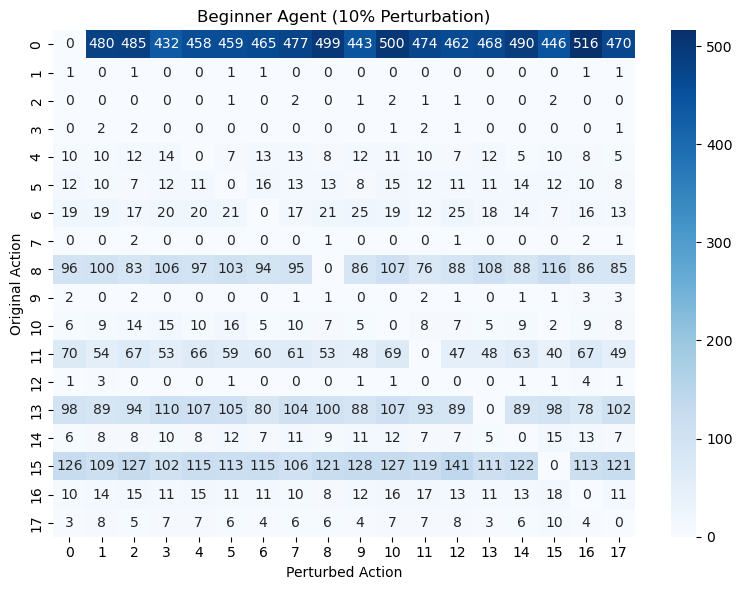

In [2]:
dataset_path = 'datasets/beginner_logs/seaquest_beginner_perturb10.pkl'
dataset = load_dataset(dataset_path)

info = inspect_dataset(dataset)
plot_perturbation_heatmap(dataset, title="Beginner Agent (10% Perturbation)")

Total transitions            : 158089
Number of episodes (done=True): 18
Unique original actions       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Action counts (original)      : {9: 154, 15: 662, 2: 53467, 12: 1839, 5: 704, 3: 1212, 17: 4403, 7: 355, 16: 35517, 14: 526, 4: 37403, 13: 20297, 10: 537, 11: 265, 8: 114, 0: 85, 1: 218, 6: 331}
Number of perturbed actions   : 16093
Perturbation rate             : 10.180%


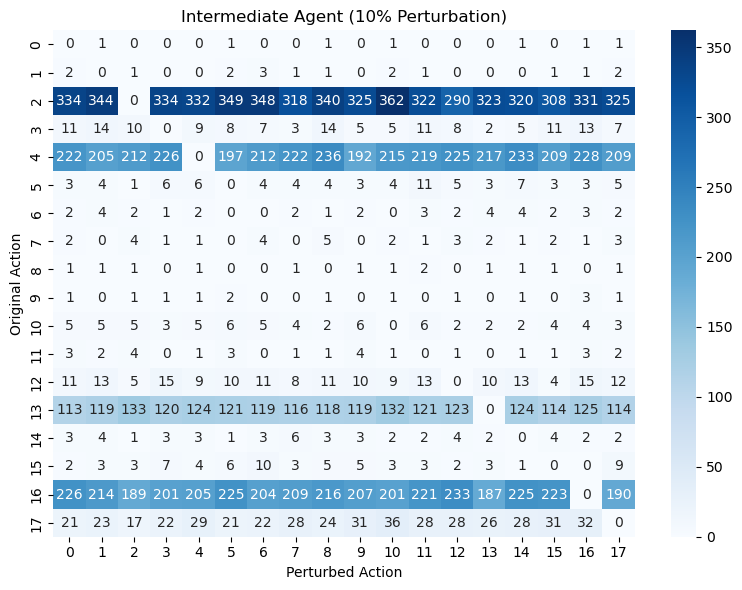

In [2]:
dataset_path = 'datasets/intermediate_logs/seaquest_intermediate_perturb10.pkl'
dataset = load_dataset(dataset_path)

info = inspect_dataset(dataset)
plot_perturbation_heatmap(dataset, title="Intermediate Agent (10% Perturbation)")

Total transitions            : 154171
Number of episodes (done=True): 21
Unique original actions       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Action counts (original)      : {6: 7838, 15: 10908, 12: 18326, 5: 6098, 16: 16087, 13: 9172, 7: 9436, 3: 21366, 14: 8430, 11: 12428, 2: 9743, 8: 4213, 9: 11167, 17: 3850, 10: 1312, 0: 1476, 4: 1444, 1: 877}
Number of perturbed actions   : 15709
Perturbation rate             : 10.189%


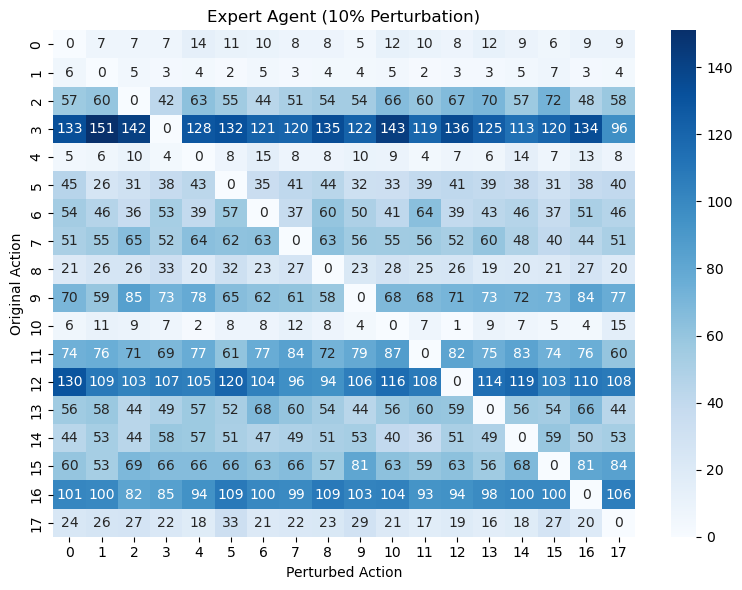

In [2]:
dataset_path = 'datasets/expert_logs/seaquest_expert_perturb10.pkl'
dataset = load_dataset(dataset_path)

info = inspect_dataset(dataset)
plot_perturbation_heatmap(dataset, title="Expert Agent (10% Perturbation)")

Check all datasets for consistency. This includes checking the number of transitions, the action space, and the structure of the dataset.

In [2]:
dataset_paths = [        
    'datasets/beginner_logs/seaquest_beginner_perturb0.pkl',
    'datasets/beginner_logs/seaquest_beginner_perturb5.pkl',
    'datasets/beginner_logs/seaquest_beginner_perturb10.pkl',
    'datasets/beginner_logs/seaquest_beginner_perturb20.pkl',
]

for path in dataset_paths:
    print("="*60)
    validate_dataset(path)

seaquest_beginner_perturb0.pkl
    Total transitions      : 155813
    Perturbed actions      : 0
    Wrong perturbations    : 0
    Diagonal (same action) : 0
    Perturbation rate      : 0.00%
Perturbation logic valid.

Episode Analysis for seaquest_beginner_perturb0.pkl
    ➤ Action space size    : 18
    ➤ Number of episodes   : 27
    ➤ Reward range         : 140.0 to 340.0
    ➤ Mean reward          : 245.93
    ➤ Episode Length range : 3297 to 8730
    ➤ Mean episode length  : 5770.85
    ➤ Last episode cut?    : No
    ➤ Last episode length  : N/A
seaquest_beginner_perturb5.pkl
    Total transitions      : 156685
    Perturbed actions      : 8009
    Wrong perturbations    : 0
    Diagonal (same action) : 0
    Perturbation rate      : 5.11%
Perturbation logic valid.

Episode Analysis for seaquest_beginner_perturb5.pkl
    ➤ Action space size    : 18
    ➤ Number of episodes   : 25
    ➤ Reward range         : 100.0 to 400.0
    ➤ Mean reward          : 264.80
    ➤ Episode Len

In [2]:
dataset_paths = [        
    'datasets/intermediate_logs/seaquest_intermediate_perturb0.pkl',
    'datasets/intermediate_logs/seaquest_intermediate_perturb5.pkl',
    'datasets/intermediate_logs/seaquest_intermediate_perturb10.pkl',
    'datasets/intermediate_logs/seaquest_intermediate_perturb20.pkl',
]

for path in dataset_paths:
    print("="*60)
    validate_dataset(path)

seaquest_intermediate_perturb0.pkl
    Total transitions      : 158185
    Perturbed actions      : 0
    Wrong perturbations    : 0
    Diagonal (same action) : 0
    Perturbation rate      : 0.00%
Perturbation logic valid.

Episode Analysis for seaquest_intermediate_perturb0.pkl
    ➤ Action space size    : 18
    ➤ Number of episodes   : 20
    ➤ Reward range         : 500.0 to 800.0
    ➤ Mean reward          : 664.00
    ➤ Episode Length range : 6342 to 9082
    ➤ Mean episode length  : 7909.25
    ➤ Last episode cut?    : No
    ➤ Last episode length  : N/A
seaquest_intermediate_perturb5.pkl
    Total transitions      : 157273
    Perturbed actions      : 8039
    Wrong perturbations    : 0
    Diagonal (same action) : 0
    Perturbation rate      : 5.11%
Perturbation logic valid.

Episode Analysis for seaquest_intermediate_perturb5.pkl
    ➤ Action space size    : 18
    ➤ Number of episodes   : 18
    ➤ Reward range         : 680.0 to 800.0
    ➤ Mean reward          : 756.67
 

In [2]:
dataset_paths = [        
    'datasets/expert_logs/seaquest_expert_perturb0.pkl',
    'datasets/expert_logs/seaquest_expert_perturb5.pkl',
    'datasets/expert_logs/seaquest_expert_perturb10.pkl',
    'datasets/expert_logs/seaquest_expert_perturb20.pkl',
]

for path in dataset_paths:
    print("="*60)
    validate_dataset(path)

seaquest_expert_perturb0.pkl
    Total transitions      : 150305
    Perturbed actions      : 0
    Wrong perturbations    : 0
    Diagonal (same action) : 0
    Perturbation rate      : 0.00%
Perturbation logic valid.

Episode Analysis for seaquest_expert_perturb0.pkl
    ➤ Action space size    : 18
    ➤ Number of episodes   : 20
    ➤ Reward range         : 540.0 to 1620.0
    ➤ Mean reward          : 1139.00
    ➤ Episode Length range : 4602 to 9685
    ➤ Mean episode length  : 7515.25
    ➤ Last episode cut?    : No
    ➤ Last episode length  : N/A
seaquest_expert_perturb5.pkl
    Total transitions      : 150697
    Perturbed actions      : 7689
    Wrong perturbations    : 0
    Diagonal (same action) : 0
    Perturbation rate      : 5.10%
Perturbation logic valid.

Episode Analysis for seaquest_expert_perturb5.pkl
    ➤ Action space size    : 18
    ➤ Number of episodes   : 22
    ➤ Reward range         : 560.0 to 1560.0
    ➤ Mean reward          : 992.73
    ➤ Episode Length r